In [62]:
#Imports
from textblob import TextBlob
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV

df = pd.read_csv('../data/small_merged_chats')
sw = stopwords.words('english')

# Assign Labels

In [57]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

vad = SentimentIntensityAnalyzer()

In [58]:
df = df.dropna(subset = ['body'])

### Clean up messages first

In [60]:
#Get rid of chats with links (often promo)
def ad(chat):
    result = False
    result = bool(re.search(r'www\.[a-z]?\.?(com)+|[a-z]+\.(com)', chat))
    result = bool(re.search(r'http\S+', chat))
    return result

df['is_ad'] = df['body'].apply(ad)

df = df[df['is_ad'] == False]

In [4]:
#change popular emojis to one type so no variants
def emoji_shorten(chat):
    chat = re.sub(r'(?i) \bpog(\w)*\b |\bpog(\w)*\b', '', chat)
    chat = re.sub(r'(?i) \blul(\w)*\b |\blul(\w)*\b', '', chat)
    chat = re.sub(r'(?i) \bkappa(\w)*\b |\bkappa(\w)*\b', '', chat)
    return chat

df['chats'] = df.body.apply(lambda x: emoji_shorten(x))

In [5]:
df['chats'] = df.body.apply(lambda x: emoji_shorten(x))

In [6]:
df = df.drop(['is_ad'], axis = 1)

In [9]:
#Words to add to VADER
# EMOTES: https://dl.acm.org/doi/10.1145/3365523
new_words = {
    'noice': 1.8,
    'scum': -2.0,
    'kap': 0.5,
    'kappa': 0.5,
    'lul': 1.8,
    'omegalol': 1.8,
    'strats': 2.0,
    'rekt': 0,
    'owo': 1.0,
    'tweaker': -2.3,
    'pog': 2.8,
    'pag': 2.8,
    'incel': -3.1,
    'tilted': -0.7,
    'feelsbadman': -2.6,
    'feelsgoodman': 3.7,
    'trash': -2.0,
    'rip': -1.2,
    'ez': 1.9,
    'clap': 2.7,
    'hyperbruh': -0.6,
    'f': 0.5,
    'F': 0.5,
    'discord': 0,
    'PJSalt': -1.2,
    'Kreygasm': 2.8,
    'kreygasm': 2.8,
    'homo': -3.5,
    'clip': 0.5,
    'rAcIsM': -3.1,
    'based': 2.0,
    'Based': 2.0,
    'PepeHands': -1.7,
    'WutFace': -1.7,
    'FailFish': -2.0,
    'BabyRage': -1.6,
    'ANELE': -0.8,
    'haHAA': -0.5,
    'ResidentSleeper': -1.2,
    'cmonBruh': -1.0
}

vad.lexicon.update(new_words)

In [101]:
if 'gang' in not_in_vocab:
    print('yes')

yes


In [104]:
vad.lexicon['notification']

KeyError: 'notification'

In [78]:
tt = TweetTokenizer()
all_words = []
for chat in df['chats']:
    all_words.extend(tt.tokenize(chat))

In [79]:
vocab = set(all_words)
not_in_vocab = []
for word in vocab:
    if word in vad.lexicon:
        continue
    else:
        not_in_vocab.append(word)

In [80]:
len(not_in_vocab)

34352

In [160]:
not_in_vocab

### Assign the labels here

In [10]:
positive = 0
negative = 0
neutral = 0
polarity = 0
neutral_list = []
negative_list = []
positive_list = []
for chat in df.chats:
    analysis = TextBlob(chat)
    vad = SentimentIntensityAnalyzer()
    vad.lexicon.update(new_words)
    score = vad.polarity_scores(chat)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    polarity += analysis.sentiment.polarity
 
    if neg > pos:
        negative_list.append(chat)
        negative += 1
    elif pos > neg:
        positive_list.append(chat)
        positive += 1
 
    elif pos == neg:
        neutral_list.append(chat)
        neutral += 1

In [108]:
print(len(neutral_list))
print(len(negative_list))
print(len(positive_list))

68112
11585
22786


In [161]:
negative_list

# Add labels to dataset

In [11]:
df["label"] = np.where(df["chats"].isin(negative_list), 1, 0)

# Cleaning chats for model

In [12]:
#Functions to tokenize text
from nltk.stem.snowball import SnowballStemmer

#Replaces pos tags with lemmatize compatable tags
def pos_replace(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
#Makes list of punctuation to exclude, keeps certain symbols
punct = list(string.punctuation)
keep_punct = ['?', '!', '@', ',', '.']
punct = [p for p in punct if p not in keep_punct]

#Removes non-ASCII characters (aka emojis that cant be converted to original symbol)
def remove_junk(tweet):
    return ''.join([i if ord(i) < 128 else ' ' for i in tweet])
    
"""
Try handling misspellings?
True reduce_len = True
"""

def chat_tokenizer(doc, stop_words = sw):
    #Any regex needed
    doc = re.sub(r'http\S+', '', doc)
    #Gets rid of weird characters
    doc = remove_junk(doc)
    #Tokenizes using NLTK Twitter Tokenizer as similar to tweets
    chat_token = TweetTokenizer(strip_handles = True)
    doc = chat_token.tokenize(doc)
    #Gets rid of numbers
#     doc_2 = []
#     for w in doc:
#         if any([c.isdigit() for c in w]):
#             pass
#         else:
#             doc_2.append(w)
    #Gets rid of leftover stopwords/punctuation
    #doc = [w for w in doc if w.lower() not in sw]
    doc = [w for w in doc if w not in punct]
    #Stemmer
#     snows = SnowballStemmer('english')
#     doc = [snows.stem(w) for w in doc]
    #Lemmatizes tokens
    doc = pos_tag(doc)
    doc = [(w[0], pos_replace(w[1])) for w in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    
    return doc

# Data Exploration

<ipython-input-12-e30479c4c8b0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_vid['time'] = one_vid['offset'] // 60


<AxesSubplot:xlabel='time'>

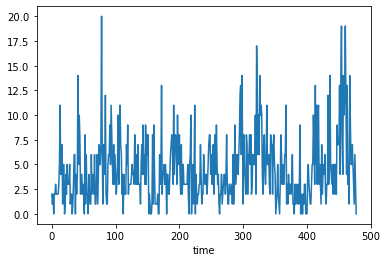

In [12]:
#Graphing hate over course of a single stream
one_vid = df[df['video_id'] == 262866347]
one_vid['time'] = one_vid['offset'] // 60
graph = one_vid.groupby('time')['label'].sum()
graph.plot()

<AxesSubplot:>

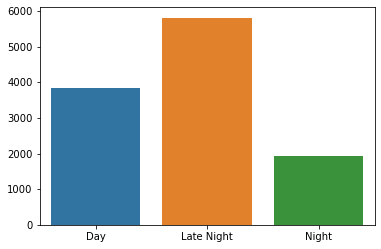

In [19]:
#Most frequent time of day for hate speech
graph = df.groupby('day_night')['label'].sum()
bar_heights = list(graph.values)
index = list(graph.index)

fig, ax = plt.subplots()
sns.barplot(x = index, y = bar_heights)

<AxesSubplot:>

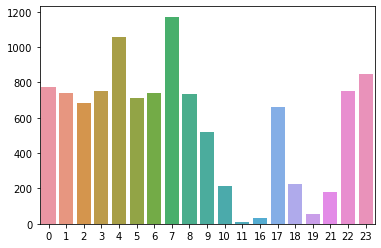

In [150]:
graph = df.groupby('hour')['label'].sum()
bar_heights = list(graph.values)
index = list(graph.index)

fig, ax = plt.subplots()
sns.barplot(x = index, y = bar_heights)

<AxesSubplot:>

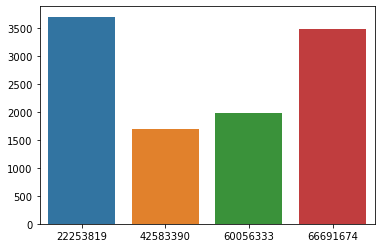

In [151]:
#Hate per streamer
graph = df.groupby('channel_id')['label'].sum()
bar_heights = list(graph.values)
index = list(graph.index)

fig, ax = plt.subplots()
sns.barplot(x = index, y = bar_heights)

<AxesSubplot:>

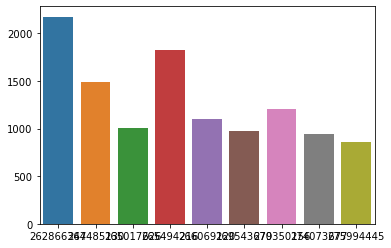

In [13]:
#Hate per stream
graph = df.groupby(['video_id'])['label'].sum()
bar_heights = list(graph.values)
index = list(graph.index)

fig, ax = plt.subplots()
sns.barplot(x = index, y = bar_heights)

<AxesSubplot:>

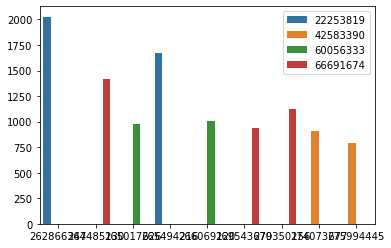

In [153]:
#Hate per stream by creator
graph = df.groupby(['channel_id', 'video_id'])['label'].sum()
video = []
creator = []
for i in graph.index:
    creator.append(i[0])
    video.append(i[1])
height = graph.values

fig, ax = plt.subplots()
sns.barplot(x = video, y = height, hue = creator)

# Feature Engineering

In [14]:
#Hour of stream
df['created_at'] = pd.to_datetime(df['created_at'])
df['hour'] = df.created_at.apply(lambda x: x.hour)

#Sorts streams into night/day
def day_night(hour):
    if (hour >= 7) and (hour < 20):
        return 'Day'
    elif (hour >= 20) and (hour <= 23):
        return 'Night'
    else:
        return 'Late Night'
df['day_night'] = df.hour.apply(day_night)

In [15]:
#Has emojis
def any_emojis(emotes):
    if emotes[2] == 'N':
        return 0
    else:
        return 1
    
#Ratio capital to length tweet
def capital_letter_ratio(chat):
    if type(chat) == float:
        return 0
    if len(chat) == 0:
        return 0
    capital_count = 0
    for c in chat:
        if c.isupper():
            capital_count += 1
    return capital_count / len(chat)

In [16]:
#Convert offset to minutes not seconds
df['stream_min'] = df['offset'] // 60

#Adds if chat contains emojis or not
df['any_emojis'] = df.emotes.apply(any_emojis)

#Adds ratio of capital letters
df['cap_ratio'] = df.twitch_chat.apply(capital_letter_ratio)

In [17]:
#Length of stream
graph = df.groupby(['video_id'])['offset'].max()
videos = list(graph.index)
max_time = list(graph.values)
time_pairings = []
for i, v in enumerate(videos):
    time_pairings.append((videos[i], max_time[i]))
    
def find_time(video):
    for pair in time_pairings:
        if video == pair[0]:
            return pair[1]

df['max_time'] = df.video_id.apply(find_time)
df['offset_percent'] = (df.offset / df.max_time) * 100

In [18]:
#User post frequency
import collections

counter = collections.Counter(df.commenter_id)

def commenter_count(id):
    return counter[id]

df['total_comments'] = df.commenter_id.apply(commenter_count)

# First Simple Model

In [19]:
df.label.value_counts(normalize = True)

0    0.887196
1    0.112804
Name: label, dtype: float64

In [39]:
from sklearn.metrics import recall_score, accuracy_score

y = df['label']
X = df['chats']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 213)

first = imbpipeline(steps=[
    ('preproc', CountVectorizer(lowercase = False, tokenizer = chat_tokenizer)),
    ('smote', SMOTE(sampling_strategy = 'minority', random_state = 213)),
    ('dtc', DecisionTreeClassifier(random_state = 213, max_depth = 5))
])

first.fit(X_train, y_train)
preds = first.predict(X_train)
print("Training Score:", recall_score(preds, y_train))
scores = np.mean(cross_val_score(first, X_train, y_train, cv = 5, scoring = 'recall'))
print("Validation Score:" + str(scores))

Pipeline(steps=[('preproc',
                 CountVectorizer(lowercase=False,
                                 tokenizer=<function chat_tokenizer at 0x7fc8c093c940>)),
                ('smote',
                 SMOTE(random_state=213, sampling_strategy='minority')),
                ('dtc', DecisionTreeClassifier(max_depth=5, random_state=213))])

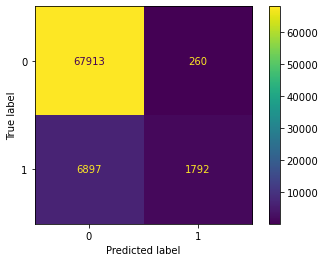

In [114]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

y_hat = first.predict(X_train)
cm = confusion_matrix(y_train, y_hat)
cmdis = ConfusionMatrixDisplay(cm)
cmdis.plot();

# Iterations

In [20]:
df['channel_id'] = df['channel_id'].astype(str)
df['video_id'] = df['video_id'].astype(str)

## Multinomial Bayes + Complement Bayes

In [22]:
from sklearn.metrics import recall_score, accuracy_score, make_scorer
from sklearn.model_selection import cross_validate

#Creates features and target then performs train test split
y = df['label']
X = df[['chats', 'channel_id', 'video_id', 'hour', 'day_night', 
            'any_emojis', 'cap_ratio', 'offset_percent', 'total_comments']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 213)

count_vec = ColumnTransformer([
    ('cv', CountVectorizer(lowercase = False, tokenizer = chat_tokenizer), 'chats'),
    ('ohe', OneHotEncoder(), ['channel_id', 'video_id', 'day_night'])],
    remainder = 'passthrough')

mnb_cv = imbpipeline(steps=[
    ('preproc', count_vec),
    ('smote', SMOTE(sampling_strategy = 'minority', random_state = 213)),
    ('mnb', MultinomialNB())
])

#Fits model and prints training score
mnb_cv.fit(X_train, y_train)
preds = mnb_cv.predict(X_train)
print("Training Recall:", recall_score(preds, y_train))
print("Training Accuracy:", mnb_cv.score(X_train, y_train))
#Cross validates model and prints average result
scoring = {
    'acc': make_scorer(accuracy_score),
    'rec': 'recall'
}
scores = cross_validate(mnb_cv, X_train, y_train, cv = 5, scoring = scoring)
print("Validation Recall:" + str(np.mean(scores['test_rec'])))
print("Validation Accuracy:" + str(np.mean(scores['test_acc'])))

In [156]:
tfidf_vec = ColumnTransformer([
    ('cv', TfidfVectorizer(lowercase = False, tokenizer = chat_tokenizer), 'chats'),
    ('ohe', OneHotEncoder(), ['channel_id', 'video_id', 'day_night'])],
    remainder = 'passthrough')

mnb_tfidf = imbpipeline(steps=[
    ('preproc', tfidf_vec),
    ('smote', SMOTE(sampling_strategy = 'minority', random_state = 213)),
    ('mnb', MultinomialNB())
])

#Fits model and prints training score
mnb_tfidf.fit(X_train, y_train)
preds = mnb_cv.predict(X_train)
print("Training Recall:", recall_score(preds, y_train))
print("Training Accuracy:", mnb_cv.score(X_train, y_train))
#Cross validates model and prints average result
scores = cross_validate(mnb_tfidf, X_train, y_train, cv = 5, scoring = scoring)
print("Validation Recall:" + str(np.mean(scores['test_rec'])))
print("Validation Accuracy:" + str(np.mean(scores['test_acc'])))

Training Recall: 0.21377432125108797
Training Accuracy: 0.6216856183809946
Validation Recall:0.7881241747838456
Validation Accuracy:0.5588586920856187


In [159]:
from sklearn.naive_bayes import ComplementNB

cnb = imbpipeline(steps=[
    ('preproc', count_vec),
    ('mnb', ComplementNB())
])

#Fits model and prints training score
cnb.fit(X_train, y_train)
preds = cnb.predict(X_train)
print("Training Recall:", recall_score(preds, y_train))
print("Training Accuracy:", cnb.score(X_train, y_train))
#Cross validates model and prints average result
scores = cross_validate(cnb, X_train, y_train, cv = 5, scoring = scoring)
print("Validation Recall:" + str(np.mean(scores['test_rec'])))
print("Validation Accuracy:" + str(np.mean(scores['test_acc'])))

Training Recall: 0.1985851298828398
Training Accuracy: 0.6064635320444433
Validation Recall:0.7808720112517581
Validation Accuracy:0.6130987245617645


### Grid Search

In [162]:
#Creates parameters to test
params = {
    'preproc__cv__max_features': [None, 4000, 8000],
    'preproc__cv__max_df': [.5, .8, 1],
    'preproc__cv__ngram_range': [(1,1), (2,2)]
}

#Fits gridsearch on model and prints out the best parameters
search = GridSearchCV(mnb_cv, param_grid = params, scoring = scoring, cv = 3, refit = 'rec')
search.fit(X_train, y_train)
search.best_params_

{'preproc__cv__max_df': 0.5,
 'preproc__cv__max_features': None,
 'preproc__cv__ngram_range': (1, 1)}

In [163]:
count_vec = ColumnTransformer([
    ('cv', CountVectorizer(max_df = .5, lowercase = False, tokenizer = chat_tokenizer), 'chats'),
    ('ohe', OneHotEncoder(), ['channel_id', 'video_id', 'day_night'])],
    remainder = 'passthrough')

mnb_tuned = imbpipeline(steps=[
    ('preproc', count_vec),
    ('smote', SMOTE(sampling_strategy = 'minority', random_state = 213)),
    ('mnb', MultinomialNB())
])

#Fits model and prints training score
mnb_tuned.fit(X_train, y_train)
preds = mnb_tuned.predict(X_train)
print("Training Recall:", recall_score(preds, y_train))
print("Training Accuracy:", mnb_tuned.score(X_train, y_train))
#Cross validates model and prints average result
scores = cross_validate(mnb_tuned, X_train, y_train, cv = 5, scoring = scoring)
print("Validation Recall:" + str(np.mean(scores['test_rec'])))
print("Validation Accuracy:" + str(np.mean(scores['test_acc'])))

Training Recall: 0.21377432125108797
Training Accuracy: 0.6216856183809946
Validation Recall:0.8341574066897082
Validation Accuracy:0.597733555553152


## Logistic Regression

<AxesSubplot:>

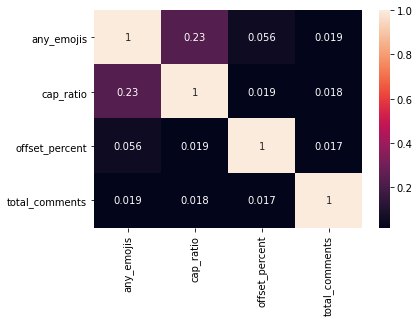

In [23]:
cont = df[['any_emojis', 'cap_ratio', 'offset_percent', 'total_comments']]
sns.heatmap(cont.corr().abs(), annot = True)

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate

#Get rid of channel_id + hour to avoid multicolinearity w/ video_id and day_night
y = df['label']
X = df[['chats', 'video_id', 'day_night', 
            'any_emojis', 'cap_ratio', 'offset_percent', 'total_comments']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 213)

count_vec = ColumnTransformer([
    ('cv', CountVectorizer(lowercase = False, tokenizer = chat_tokenizer), 'chats'),
    ('ohe', OneHotEncoder(), ['video_id', 'day_night']),
    ('ss', StandardScaler(), ['any_emojis', 'cap_ratio', 'offset_percent', 'total_comments'])],
    remainder = 'passthrough')

logreg = imbpipeline(steps=[
    ('preproc', count_vec),
    ('smote', SMOTE(sampling_strategy = 'minority', random_state = 213)),
    ('lr', LogisticRegression(max_iter = 10000, random_state = 213))
])

#Fits model and prints training score
logreg.fit(X_train, y_train)

preds = logreg.predict(X_train)
print("Training Recall:", recall_score(preds, y_train))
print("Training Accuracy:", logreg.score(X_train, y_train))

#Cross validates model and prints average result
scores = cross_validate(logreg, X_train, y_train, cv = 5, scoring = scoring)
print("Validation Recall:" + str(np.mean(scores['test_rec'])))
print("Validation Accuracy:" + str(np.mean(scores['test_acc'])))

Training Recall: 0.8499794492396219
Training Accuracy: 0.9755274261603376
Validation Recall:0.8428202230109786
Validation Accuracy:0.9579746835443037


In [44]:
#Creates parameters to test
params = {
    'preproc__cv__max_features': [None, 4000, 8000],
    'preproc__cv__max_df': [.5, .8, 1],
    'preproc__cv__ngram_range': [(1,1), (2,2)],
    'preproc__cv__lowercase': [False, True]
}

#Fits gridsearch on model and prints out the best parameters
search = GridSearchCV(logreg, param_grid = params, scoring = scoring, cv = 3, refit = 'rec')
search.fit(X_train, y_train)
search.best_params_

{'preproc__cv__lowercase': True,
 'preproc__cv__max_df': 0.5,
 'preproc__cv__max_features': 8000,
 'preproc__cv__ngram_range': (1, 1)}

# FINAL MODEL

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate

#Get rid of channel_id + hour to avoid multicolinearity w/ video_id and day_night
y = df['label']
X = df[['chats', 'video_id', 'day_night', 
            'any_emojis', 'cap_ratio', 'offset_percent', 'total_comments']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 213)

count_vec = ColumnTransformer([
    ('cv', CountVectorizer(lowercase = True, max_df = .5, max_features = 8000, tokenizer = chat_tokenizer), 'chats'),
    ('ohe', OneHotEncoder(), ['video_id', 'day_night']),
    ('ss', StandardScaler(), ['any_emojis', 'cap_ratio', 'offset_percent', 'total_comments'])],
    remainder = 'passthrough')

logreg_tune = imbpipeline(steps=[
    ('preproc', count_vec),
    ('smote', SMOTE(sampling_strategy = 'minority', random_state = 213)),
    ('lr', LogisticRegression(max_iter = 10000, random_state = 213))
])

#Fits model and prints training score
logreg_tune.fit(X_train, y_train)
preds = logreg_tune.predict(X_train)
print("Training Recall:", recall_score(preds, y_train))
print("Training Accuracy:", logreg_tune.score(X_train, y_train))

#Cross validates model and prints average result
scores = cross_validate(logreg_tune, X_train, y_train, cv = 5, scoring = scoring)
print("Validation Recall:" + str(np.mean(scores['test_rec'])))
print("Validation Accuracy:" + str(np.mean(scores['test_acc'])))

Training Recall: 0.8193034825870646
Training Accuracy: 0.9704122038299253
Validation Recall:0.8799588877211768
Validation Accuracy:0.9588834793898086


#### Assumption test

<ipython-input-49-812980efa55c>:3: RuntimeWarning: divide by zero encountered in true_divide
  log_odds = np.log(pred / (1 - pred))
<ipython-input-49-812980efa55c>:3: RuntimeWarning: divide by zero encountered in log
  log_odds = np.log(pred / (1 - pred))


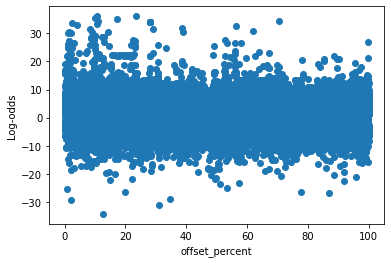

In [49]:
#Grabs probabilities and calculates log odds
pred = logreg_tune.predict_proba(X_train)[:, 0]
log_odds = np.log(pred / (1 - pred))
#Plots log odds versus continuous variable to check for linearity
plt.scatter(x = X_train['offset_percent'], y = log_odds)
plt.xlabel("offset_percent")
plt.ylabel("Log-odds")
plt.show()

In [225]:
words = logreg.named_steps["preproc"].transformers_[0][1].get_feature_names()
ohe = logreg.named_steps["preproc"].transformers_[1][1].get_feature_names()
numbers = logreg.named_steps["preproc"].transformers_[2][2]

columns = [*words, *ohe, *numbers]

coef_dict = {}
for coef, feat in zip(logreg['lr'].coef_[0, :], columns):
    coef_dict[feat] = coef

'rip'

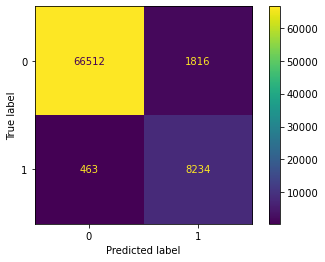

In [51]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

y_hat = logreg_tune.predict(X_train)
cm = confusion_matrix(y_train, y_hat)
cmdis = ConfusionMatrixDisplay(cm)
cmdis.plot();

## Random Forest

In [230]:
from sklearn.ensemble import RandomForestClassifier 
y = df['label']
X = df[['chats', 'channel_id', 'video_id', 'hour', 'day_night', 
            'any_emojis', 'cap_ratio', 'offset_percent', 'total_comments']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 213)

count_vec = ColumnTransformer([
    ('cv', CountVectorizer(lowercase = False, tokenizer = chat_tokenizer), 'chats'),
    ('ohe', OneHotEncoder(), ['channel_id', 'video_id', 'day_night'])],
    remainder = 'passthrough')

rfc = imbpipeline(steps=[
    ('preproc', count_vec),
    ('smote', SMOTE(sampling_strategy = 'minority', random_state = 213)),
    ('rf', RandomForestClassifier(random_state = 213))
])

#Fits model and prints training score
rfc.fit(X_train, y_train)
preds = rfc.predict(X_train)
print("Training Recall:", recall_score(preds, y_train))
print("Training Accuracy:", rfc.score(X_train, y_train))
#Cross validates model and prints average result
scores = cross_validate(rfc, X_train, y_train, cv = 5, scoring = scoring)
print("Validation Recall:" + str(np.mean(scores['test_rec'])))
print("Validation Accuracy:" + str(np.mean(scores['test_acc'])))

Training Recall: 1.0
Training Accuracy: 1.0
Validation Recall:0.3858905179558423
Validation Accuracy:0.9256979978770259


In [239]:
#Creates parameters to test
params = {
    'rf__criterion': ['gini', 'entropy'],
    'rf__max_depth': [None, 50, 100],
    'rf__min_samples_split': [2, 5, 10]
}

#Fits gridsearch on model and prints out the best parameters
search = GridSearchCV(rfc, param_grid = params, scoring = scoring, cv = 3, refit = 'rec')
search.fit(X_train, y_train)
search.best_params_

{'rf__criterion': 'gini', 'rf__max_depth': None, 'rf__min_samples_split': 10}

In [243]:
count_vec = ColumnTransformer([
    ('cv', CountVectorizer(lowercase = False, tokenizer = chat_tokenizer), 'chats'),
    ('ohe', OneHotEncoder(), ['channel_id', 'video_id', 'day_night'])],
    remainder = 'passthrough')

rfc_tune = imbpipeline(steps=[
    ('preproc', count_vec),
    ('smote', SMOTE(sampling_strategy = 'minority', random_state = 213)),
    ('rf', RandomForestClassifier(min_samples_split = 10, random_state = 213))
])

#Fits model and prints training score
rfc_tune.fit(X_train, y_train)
preds = rfc_tune.predict(X_train)
print("Training Recall:", recall_score(preds, y_train))
print("Training Accuracy:", rfc_tune.score(X_train, y_train))
#Cross validates model and prints average result
scores = cross_validate(rfc_tune, X_train, y_train, cv = 5, scoring = scoring)
print("Validation Recall:" + str(np.mean(scores['test_rec'])))
print("Validation Accuracy:" + str(np.mean(scores['test_acc'])))

Training Recall: 0.9960725424511956
Training Accuracy: 0.998698966979782
Validation Recall:0.4344583766437246
Validation Accuracy:0.9297962645898616


In [238]:
words = rfc_tune.named_steps["preproc"].transformers_[0][1].get_feature_names()
ohe = rfc_tune.named_steps["preproc"].transformers_[1][1].get_feature_names()
numbers = ['hour', 'any_emojis', 'cap_ratio', 'offset_percent', 'total_comments']

columns = [*words, *ohe, *numbers]

for name, importance in zip(columns, rfc_tune['rf'].feature_importances_):
    print(name, importance)

no


0.038538826298286304

## SVM

In [ ]:
from sklearn.svm import SVC

count_vec = ColumnTransformer([
    ('cv', CountVectorizer(lowercase = False, tokenizer = chat_tokenizer), 'chats'),
    ('ohe', OneHotEncoder(), ['channel_id', 'video_id', 'day_night']),
    ('ss', StandardScaler(), ['hour', 'any_emojis', 'cap_ratio', 'offset_percent', 'total_comments'])],
    remainder = 'passthrough')

svm_untune = imbpipeline(steps=[
    ('preproc', count_vec),
    ('smote', SMOTE(sampling_strategy = 'minority', random_state = 213)),
    ('svm', SVC(kernel='linear', gamma='auto'))
])

#Fits model and prints training score
svm_untune.fit(X_train, y_train)
preds = svm_untune.predict(X_train)
print("Training Recall:", recall_score(preds, y_train))
print("Training Accuracy:", svm_untune.score(X_train, y_train))
#Cross validates model and prints average result
scores = cross_validate(svm_untune, X_train, y_train, cv = 5, scoring = scoring)
print("Validation Recall:" + str(np.mean(scores['test_rec'])))
print("Validation Accuracy:" + str(np.mean(scores['test_acc'])))